In [1]:
# Austin Griffith
# Python 3.6.5
# 4/25/2018

import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import networkx as nx

In [2]:
# set up plotting parameters
params = {'legend.fontsize': 20,
          'figure.figsize': (13,9),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)

In [3]:
# graph all nodes and paths
def networkCompletePlot(solution,maxNode):
    G = nx.DiGraph()
    G.add_nodes_from(range(0,maxNode+1))
    for i,j in nodes:
        G.add_edge(i,j)

    # get solution nodes
    sp = [i for i,j in solution[1]]
    sp.append(end)

    colorNode = ['white' if not node in sp else 'red' for node in G.nodes()]
    title = 'Complete Network: Gamma = '+str(int(solution[0]))+', Opt Obj = '+str(round(solution[2],5))
    nx.draw_networkx(G,node_color=colorNode,node_size=200)
    plt.axis('off')
    plt.title(title)
    plt.show()

# graph path, with costs on edges
def networkPathPlot(solution,maxNode,cost):
    # get solution nodes
    sp = [i for i,j in solution[1]]
    sp.append(end)

    # set up random position values
    a = np.arange(maxNode+1)
    b = np.arange(maxNode+1)
    np.random.shuffle(a)
    posArray = np.array([a,b]).transpose()

    positions = {}
    for p in range(0,len(sp)):
        L = posArray[p]
        positions[sp[p]] = (L[0],L[1])

    # set up network graph
    G = nx.DiGraph()
    G.add_nodes_from(sp)

    for i,j in tuplelist(solution[1]):
        G.add_edge(i,j)

    labels = {}
    for i in solution[1]:
        labels[i] = round(c[i],3)

    title = 'Optimal Path: Gamma = '+str(int(solution[0]))+', Opt Obj = '+str(round(solution[2],5))
    nx.draw_networkx(G,positions,node_size=350)
    nx.draw_networkx_edge_labels(G,positions,edge_labels=labels)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [4]:
# pull data
edges = pd.read_csv('edge_data.csv')
edges['i'] = np.int64(edges['i'])
edges['j'] = np.int64(edges['j'])

# create dictionaries of edge values
c = {}
d = {}
nodes = tuplelist()
for i in edges.index:
    c[edges['i'][i],edges['j'][i]] = edges['c(ij)'][i]
    d[edges['i'][i],edges['j'][i]] = edges['d(ij)'][i]
    nodes.append((edges['i'][i],edges['j'][i]))

maxNodes = max(edges['j'])
minNodes = min(edges['i'])

In [5]:
# choose start and end nodes
start = 0
end = 49

# allowed edge congestions
gend = 4
gammas = np.linspace(0,gend,gend+1)
print('Allowed Congestions:')
print(gammas)

Allowed Congestions:
[ 0.  1.  2.  3.  4.]


In [6]:
# initialize model
model = Model('Shortest_Path')

# set up x binary variables, set to each location/movement
xVars = model.addVars(nodes, vtype=GRB.BINARY, name='move')
y0 = model.addVar(vtype=GRB.CONTINUOUS, name='y0')
zVars = model.addVars(nodes, lb=0.0, vtype=GRB.CONTINUOUS, name='cong')
model.update()

In [7]:
# constrain all entrance and exit nodes
enterStart = []
leaveStart = []
enterEnd = []
leaveEnd = []
for n in nodes:
    # for start nodes
    if n[0] == start:
        leaveStart.append(xVars[n])
    elif n[1] == start:
        enterStart.append(xVars[n])
    # for end nodes
    if n[0] == end:
        leaveEnd.append(xVars[n])
    elif n[1] == end:
        enterEnd.append(xVars[n])

model.addConstr(quicksum(leaveStart) == 1)
model.addConstr(quicksum(enterStart) == 0)
model.addConstr(quicksum(leaveEnd) == 0)
model.addConstr(quicksum(enterEnd) == 1)
model.update()

In [8]:
# gather all paths
paths = []
for i in range(minNodes+1,maxNodes):
    pathFrom = []
    pathTo = []
    for n in nodes:
        if n[0] == i:
            pathFrom.append(xVars[n])
        elif n[1] == i:
            pathTo.append(xVars[n])
    paths.append([pathFrom,pathTo])
model.update()

for p in paths:
    model.addConstr(quicksum(p[0]) - quicksum(p[1]) == 0.0)
model.update()

print('Example of Path Constraint for a Given Node:')
print(quicksum(p[0]) - quicksum(p[1]))

Example of Path Constraint for a Given Node:
<gurobi.LinExpr: move[48,0] + move[48,1] + move[48,2] + move[48,3] + move[48,4] + move[48,5] + move[48,7] + move[48,8] + move[48,10] + move[48,11] + move[48,12] + move[48,13] + move[48,14] + move[48,15] + move[48,16] + move[48,17] + move[48,18] + move[48,19] + move[48,20] + move[48,22] + move[48,23] + move[48,24] + move[48,25] + move[48,26] + move[48,27] + move[48,28] + move[48,29] + move[48,30] + move[48,31] + move[48,32] + move[48,33] + move[48,34] + move[48,35] + move[48,36] + move[48,37] + move[48,39] + move[48,40] + move[48,41] + move[48,42] + move[48,43] + move[48,45] + move[48,46] + move[48,47] + move[48,49] + -1.0 move[0,48] + -1.0 move[1,48] + -1.0 move[2,48] + -1.0 move[3,48] + -1.0 move[4,48] + -1.0 move[5,48] + -1.0 move[6,48] + -1.0 move[7,48] + -1.0 move[8,48] + -1.0 move[9,48] + -1.0 move[10,48] + -1.0 move[11,48] + -1.0 move[12,48] + -1.0 move[13,48] + -1.0 move[14,48] + -1.0 move[15,48] + -1.0 move[16,48] + -1.0 move[17,48] 

In [9]:
# objective function
costObj = []
for n in nodes:
    costObj.append(xVars[n]*c[n])
    model.addConstr(zVars[n] >= xVars[n]*d[n] - y0)
model.update()

print('Example of Congestion Constraint:')
print(zVars[n],' >= ',xVars[n]*d[n] - y0)

Example of Congestion Constraint:
<gurobi.Var cong[49,48]>  >=  <gurobi.LinExpr: 3.9051301780000003 move[49,48] + -1.0 y0>


In [10]:
# iterate optimization through various gammas (congestions)
output = []
for g in gammas:
    # optimize
    objective = quicksum(costObj) + g*y0 + quicksum(zVars)
    model.setObjective(objective, GRB.MINIMIZE)

    model.optimize()

    # order the printout of optimal edges
    moves = []
    for m in xVars:
        if xVars[m].x != 0:
            moves.append(m)
    order = [moves[0]]
    for i in range(len(moves)):
        for m in moves:
            if order[i][1] == m[0]:
                order.append(m)
    output.append([g,order,model.objVal])

Optimize a model with 2261 rows, 4419 columns and 11045 nonzeros
Variable types: 2210 continuous, 2209 integer (2209 binary)
Coefficient statistics:
  Matrix range     [8e-05, 5e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.2538690
Presolve removed 2211 rows and 3869 columns
Presolve time: 0.01s
Presolved: 50 rows, 550 columns, 1100 nonzeros
Variable types: 0 continuous, 550 integer (550 binary)

Root relaxation: objective 1.331944e-01, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.1331944    0.13319  0.00%     -    0s

Explored 0 nodes (22 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.133194 0.253869 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.


Explored 1 nodes (373 simplex iterations) in 0.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 1.76901 1.83394 1.99223 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.769008875000e+00, best bound 1.769008875000e+00, gap 0.0000%
Optimize a model with 2261 rows, 4419 columns and 11045 nonzeros
Variable types: 2210 continuous, 2209 integer (2209 binary)
Coefficient statistics:
  Matrix range     [8e-05, 5e+00]
  Objective range  [1e-05, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Loaded MIP start with objective 1.8923

Presolve removed 91 rows and 178 columns
Presolve time: 0.01s
Presolved: 2170 rows, 4241 columns, 10600 nonzeros
Variable types: 2121 continuous, 2120 integer (2120 binary)

Root relaxation: objective 9.929632e-01, 67 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0


For Gamma: 0.0
Path:
[(0, 23), (23, 21), (21, 47), (47, 4), (4, 22), (22, 6), (6, 45), (45, 3), (3, 18), (18, 49)]
Cost of Movement (Objective):
0.133194359


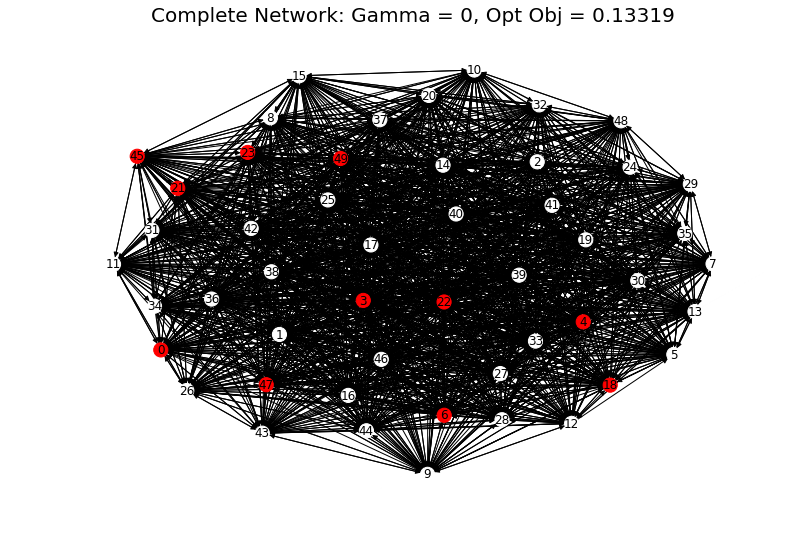

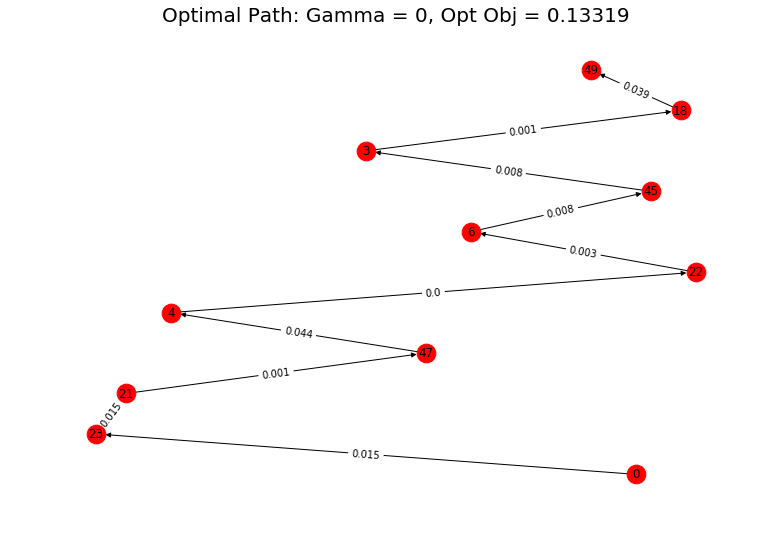


For Gamma: 1.0
Path:
[(0, 48), (48, 8), (8, 30), (30, 47), (47, 49)]
Cost of Movement (Objective):
1.299208152


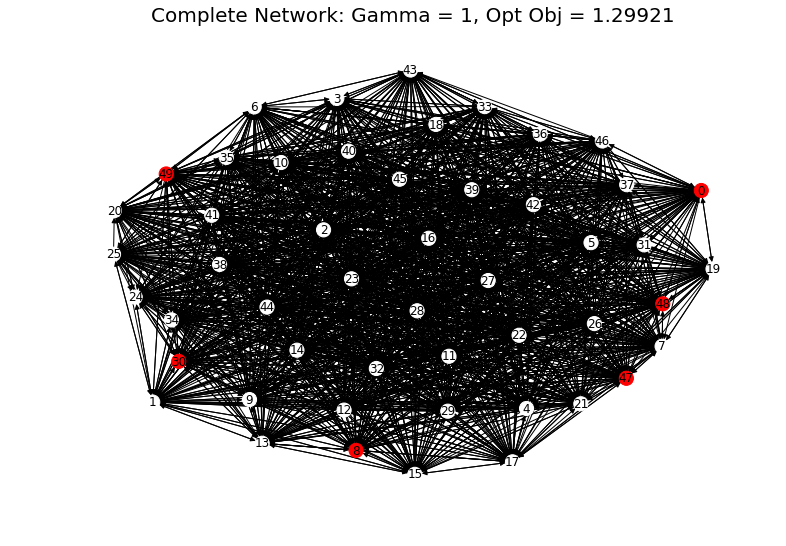

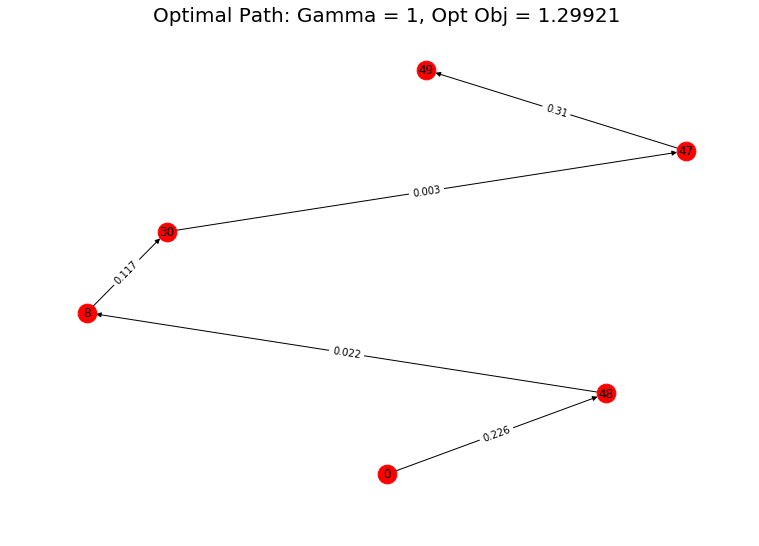


For Gamma: 2.0
Path:
[(0, 48), (48, 8), (8, 30), (30, 47), (47, 49)]
Cost of Movement (Objective):
1.6457190550000003


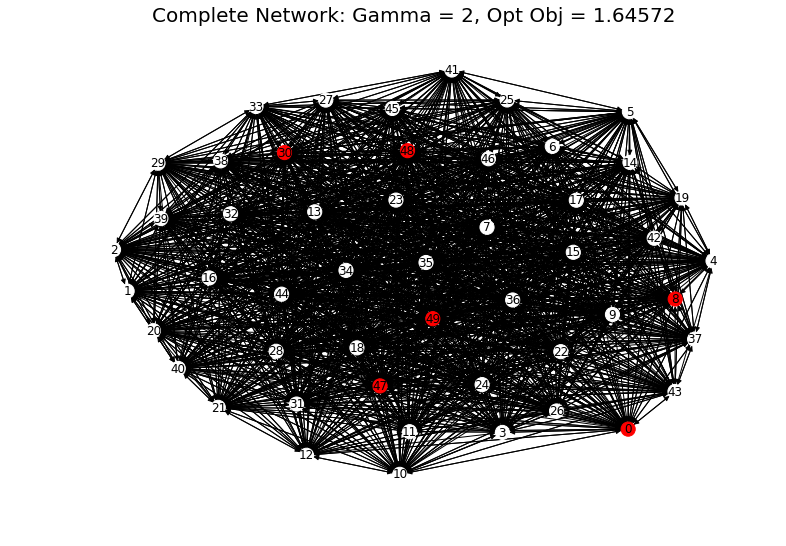

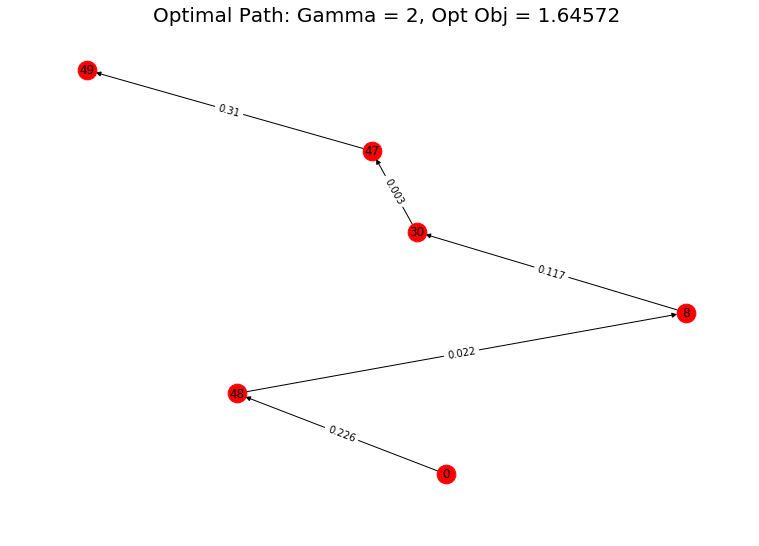


For Gamma: 3.0
Path:
[(0, 48), (48, 8), (8, 30), (30, 47), (47, 49)]
Cost of Movement (Objective):
1.7690088749999995


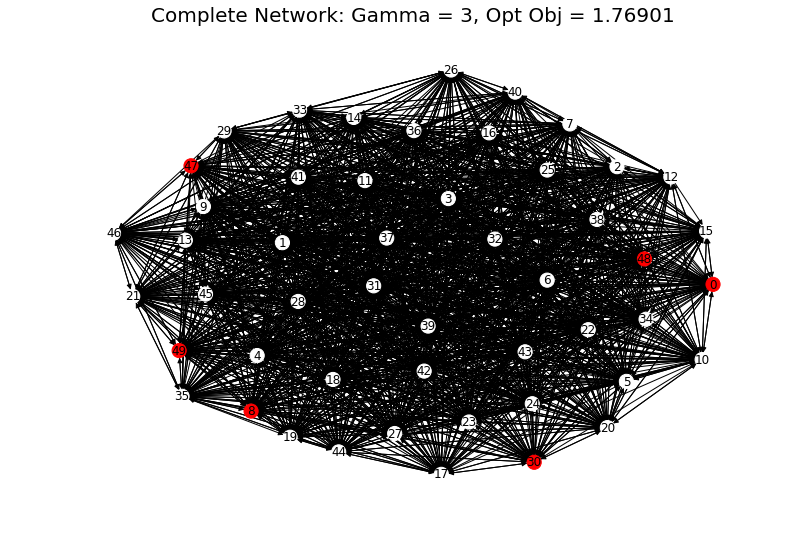

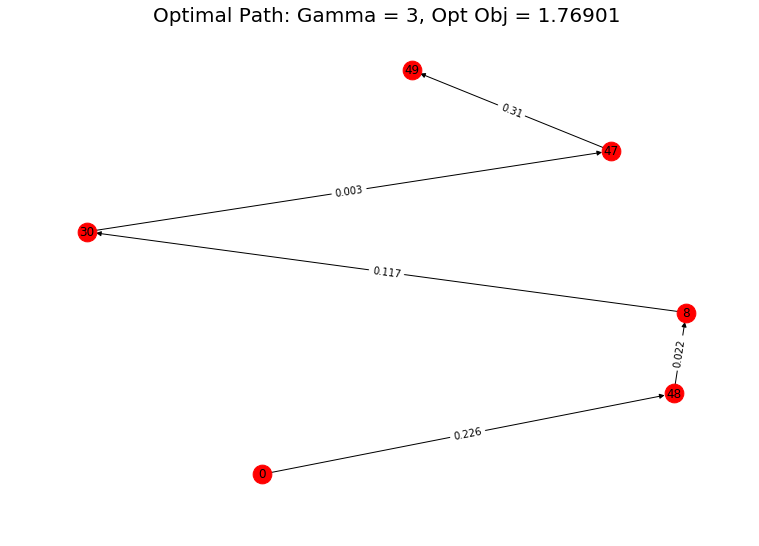


For Gamma: 4.0
Path:
[(0, 7), (7, 49)]
Cost of Movement (Objective):
1.833942446


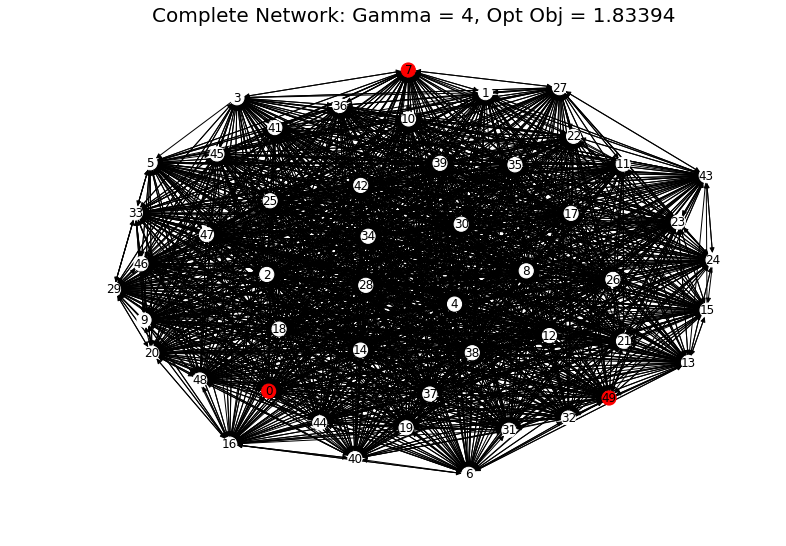

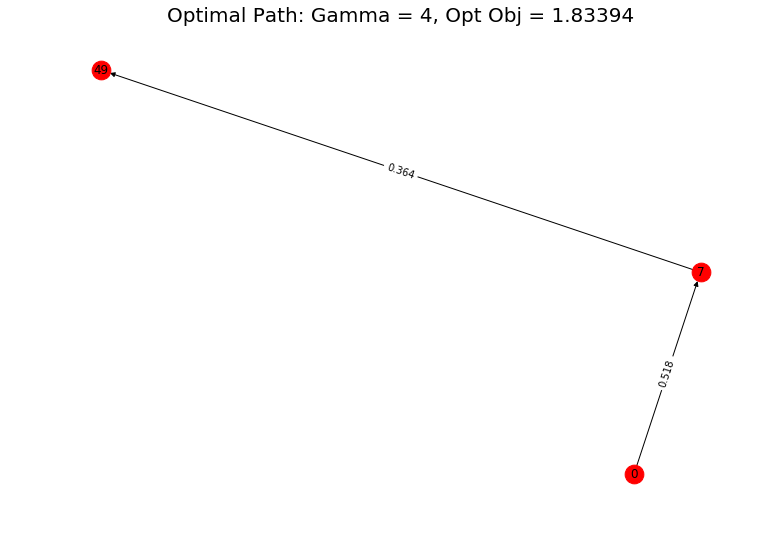

In [11]:
# print optimal values and paths, plot network
for o in output:
    print('\nFor Gamma: '+str(o[0]))
    print('Path:')
    print(o[1])
    print('Cost of Movement (Objective):')
    print(o[2])
    networkCompletePlot(o,maxNodes)
    networkPathPlot(o,maxNodes,c)